In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, average_precision_score,
                           precision_recall_curve, roc_curve, f1_score)

import xgboost as xgb
# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

#Utilities
import ipaddress
from datetime import datetime
import joblib
import pickle
from google.colab import drive, files

In [4]:
# Define data paths (adjust these paths according to your Google Drive structure)
FRAUD_DATA_PATH = '/content/drive/MyDrive/fraud_detection/Fraud_Data.csv'
IP_COUNTRY_PATH = '/content/drive/MyDrive/fraud_detection/IpAddress_to_Country.csv'
CREDITCARD_PATH = '/content/drive/MyDrive/fraud_detection/creditcard.csv'

def load_datasets():
    """Load all datasets from Google Drive with error handling"""
    datasets = {}

    try:
        # Load Fraud Data
        print("Loading Fraud_Data.csv...")
        fraud_data = pd.read_csv(FRAUD_DATA_PATH)
        datasets['fraud_data'] = fraud_data
        print(f"Loaded: {fraud_data.shape[0]} rows, {fraud_data.shape[1]} columns")

        # Load IP to Country mapping
        print("Loading IpAddress_to_Country.csv...")
        ip_country = pd.read_csv(IP_COUNTRY_PATH)
        datasets['ip_country'] = ip_country
        print(f"Loaded: {ip_country.shape[0]} IP ranges")

        # Load Credit Card Data
        print("Loading creditcard.csv...")
        creditcard_data = pd.read_csv(CREDITCARD_PATH)
        datasets['creditcard_data'] = creditcard_data
        print(f"Loaded: {creditcard_data.shape[0]} rows, {creditcard_data.shape[1]} columns")

        return datasets

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Please ensure the data files are in the correct Google Drive paths.")
        return None

In [48]:
# Load datasets
datasets = load_datasets()

if datasets:
    fraud_data = datasets['fraud_data']
    ip_country = datasets['ip_country']
    creditcard_data = datasets['creditcard_data']
    print("\nAll datasets loaded successfully!")
else:
    print("Please check your file paths and try again.")

if datasets:
    print("\n=== Fraud Data Sample ===")
    print(datasets['fraud_data'].head())

    print("\n=== IP to Country Sample ===")
    print(datasets['ip_country'].head())

    print("\n=== Credit Card Data Sample ===")
    print(datasets['creditcard_data'].head())

Loading Fraud_Data.csv...
Loaded: 151112 rows, 11 columns
Loading IpAddress_to_Country.csv...
Loaded: 138846 IP ranges
Loading creditcard.csv...
Loaded: 284807 rows, 31 columns

All datasets loaded successfully!

=== Fraud Data Sample ===
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUIT

### EXPLORATORY DATA ANALYSIS (EDA)

In [6]:
class FraudDataAnalyzer:
    """Comprehensive fraud data analysis class"""

    def __init__(self, fraud_df, creditcard_df):
        self.fraud_df = fraud_df.copy()
        self.creditcard_df = creditcard_df.copy()

In [7]:
def add_method(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

In [8]:
@add_method(FraudDataAnalyzer)
def basic_info_analysis(self):
    print("=" * 80)
    print("DATASET OVERVIEW")
    print("=" * 80)

    # Fraud Data Analysis
    print("\nFRAUD DATA (E-COMMERCE) ANALYSIS:")
    print(f"Shape: {self.fraud_df.shape}")
    print(f"Memory usage: {self.fraud_df.memory_usage().sum() / 1024**2:.2f} MB")

    print("\nColumn Information:")
    print(self.fraud_df.info())

    print("\nMissing Values:")
    missing_fraud = self.fraud_df.isnull().sum()
    print(missing_fraud[missing_fraud > 0])

    # Credit Card Data Analysis
    print("\nCREDIT CARD DATA ANALYSIS:")
    print(f"Shape: {self.creditcard_df.shape}")
    print(f"Memory usage: {self.creditcard_df.memory_usage().sum() / 1024**2:.2f} MB")

    print("\nMissing Values:")
    missing_cc = self.creditcard_df.isnull().sum()
    print(missing_cc[missing_cc > 0])

In [9]:
@add_method(FraudDataAnalyzer)
def class_imbalance_analysis(self):
    print("=" * 80)
    print("CLASS IMBALANCE ANALYSIS")
    print("=" * 80)

    # Fraud Data
    fraud_class_dist = self.fraud_df['class'].value_counts()
    fraud_imbalance_ratio = fraud_class_dist[0] / fraud_class_dist[1]
    fraud_rate = (fraud_class_dist[1] / len(self.fraud_df)) * 100

    print("\nFRAUD DATA (E-COMMERCE):")
    print(f"Legitimate transactions: {fraud_class_dist[0]:,}")
    print(f"Fraudulent transactions: {fraud_class_dist[1]:,}")
    print(f"Imbalance ratio: {fraud_imbalance_ratio:.2f}:1")
    print(f"Fraud rate: {fraud_rate:.4f}%")

    # Credit Card Data
    cc_class_dist = self.creditcard_df['Class'].value_counts()
    cc_imbalance_ratio = cc_class_dist[0] / cc_class_dist[1]
    cc_fraud_rate = (cc_class_dist[1] / len(self.creditcard_df)) * 100

    print("\nCREDIT CARD DATA:")
    print(f"Legitimate transactions: {cc_class_dist[0]:,}")
    print(f"Fraudulent transactions: {cc_class_dist[1]:,}")
    print(f"Imbalance ratio: {cc_imbalance_ratio:.2f}:1")
    print(f"Fraud rate: {cc_fraud_rate:.4f}%")

    # Visualization
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['E-commerce Fraud Distribution', 'Credit Card Fraud Distribution'],
        specs=[[{"type": "pie"}, {"type": "pie"}]]
    )

    fig.add_trace(go.Pie(labels=['Legitimate', 'Fraudulent'],
                         values=[fraud_class_dist[0], fraud_class_dist[1]],
                         marker_colors=['lightblue', 'red'],
                         textinfo='label+percent+value'),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=['Legitimate', 'Fraudulent'],
                         values=[cc_class_dist[0], cc_class_dist[1]],
                         marker_colors=['lightgreen', 'orange'],
                         textinfo='label+percent+value'),
                  row=1, col=2)

    fig.update_layout(height=400, title_text="Class Distribution Comparison")
    fig.show()

    return {
        'fraud_data': {'imbalance_ratio': fraud_imbalance_ratio, 'fraud_rate': fraud_rate},
        'creditcard_data': {'imbalance_ratio': cc_imbalance_ratio, 'fraud_rate': cc_fraud_rate}
    }

In [10]:
@add_method(FraudDataAnalyzer)
def feature_analysis(self):
    print("=" * 80)
    print("FEATURE ANALYSIS")
    print("=" * 80)

    # Fraud Data
    print("\nFRAUD DATA FEATURES:")

    numerical_cols = self.fraud_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numerical_cols:
        numerical_cols.remove('class')

    print(f"Numerical features: {numerical_cols}")
    print("\nNumerical Features Statistics:")
    print(self.fraud_df[numerical_cols].describe())

    categorical_cols = self.fraud_df.select_dtypes(include=['object']).columns.tolist()
    print(f"\nCategorical features: {categorical_cols}")

    for col in categorical_cols:
        if col not in ['user_id', 'device_id', 'ip_address']:
            print(f"\n{col.upper()} Distribution:")
            print(self.fraud_df[col].value_counts().head())

    # Credit Card Data
    print("\nCREDIT CARD FEATURES:")
    print("Features V1-V28 are PCA-transformed (anonymized)")
    print("Time and Amount are original features")

    print("\nCredit Card Statistics:")
    print(self.creditcard_df[['Time', 'Amount']].describe())

In [11]:
@add_method(FraudDataAnalyzer)
def fraud_pattern_analysis(self):
    print("=" * 80)
    print("FRAUD PATTERN ANALYSIS")
    print("=" * 80)

    # E-commerce
    print("\nE-COMMERCE FRAUD PATTERNS:")

    fraud_amounts = self.fraud_df[self.fraud_df['class'] == 1]['purchase_value']
    legit_amounts = self.fraud_df[self.fraud_df['class'] == 0]['purchase_value']

    print(f"Average fraud amount: ${fraud_amounts.mean():.2f}")
    print(f"Average legitimate amount: ${legit_amounts.mean():.2f}")
    print(f"Median fraud amount: ${fraud_amounts.median():.2f}")
    print(f"Median legitimate amount: ${legit_amounts.median():.2f}")

    fraud_age = self.fraud_df[self.fraud_df['class'] == 1]['age'].mean()
    legit_age = self.fraud_df[self.fraud_df['class'] == 0]['age'].mean()
    print(f"\nAge patterns: Fraud={fraud_age:.1f}, Legitimate={legit_age:.1f}")

    print("\nGender fraud patterns:")
    print(self.fraud_df.groupby('sex')['class'].agg(['count', 'sum', 'mean']).round(4))

    print("\nBrowser fraud patterns:")
    print(self.fraud_df.groupby('browser')['class'].agg(['count', 'sum', 'mean']).round(4).head())

    # Credit Card
    print("\nCREDIT CARD FRAUD PATTERNS:")

    cc_fraud_amounts = self.creditcard_df[self.creditcard_df['Class'] == 1]['Amount']
    cc_legit_amounts = self.creditcard_df[self.creditcard_df['Class'] == 0]['Amount']

    print(f"Average fraud amount: ${cc_fraud_amounts.mean():.2f}")
    print(f"Average legitimate amount: ${cc_legit_amounts.mean():.2f}")
    print(f"Median fraud amount: ${cc_fraud_amounts.median():.2f}")
    print(f"Median legitimate amount: ${cc_legit_amounts.median():.2f}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].hist(legit_amounts, bins=50, alpha=0.7, label='Legitimate', color='blue')
    axes[0,0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='red')
    axes[0,0].set_title('E-commerce Transaction Amounts')
    axes[0,0].set_yscale('log')
    axes[0,0].legend()

    axes[0,1].hist(np.log1p(legit_amounts), bins=50, alpha=0.7, label='Legitimate', color='blue')
    axes[0,1].hist(np.log1p(fraud_amounts), bins=50, alpha=0.7, label='Fraud', color='red')
    axes[0,1].set_title('E-commerce Log Transaction Amounts')
    axes[0,1].legend()

    axes[1,0].hist(cc_legit_amounts, bins=50, alpha=0.7, label='Legitimate', color='green')
    axes[1,0].hist(cc_fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='orange')
    axes[1,0].set_title('Credit Card Transaction Amounts')
    axes[1,0].set_yscale('log')
    axes[1,0].legend()

    axes[1,1].hist(np.log1p(cc_legit_amounts), bins=50, alpha=0.7, label='Legitimate', color='green')
    axes[1,1].hist(np.log1p(cc_fraud_amounts), bins=50, alpha=0.7, label='Fraud', color='orange')
    axes[1,1].set_title('Credit Card Log Transaction Amounts')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

DATASET OVERVIEW

FRAUD DATA (E-COMMERCE) ANALYSIS:
Shape: (151112, 11)
Memory usage: 12.68 MB

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None

Missing Values:
Series([], dtype: int64)

CREDIT CARD DATA ANALYSIS:
Shape: (284807, 31)
Memory usage: 67.

FEATURE ANALYSIS

FRAUD DATA FEATURES:
Numerical features: ['user_id', 'purchase_value', 'age', 'ip_address']

Numerical Features Statistics:
             user_id  purchase_value            age    ip_address
count  151112.000000   151112.000000  151112.000000  1.511120e+05
mean   200171.040970       36.935372      33.140704  2.152145e+09
std    115369.285024       18.322762       8.617733  1.248497e+09
min         2.000000        9.000000      18.000000  5.209350e+04
25%    100642.500000       22.000000      27.000000  1.085934e+09
50%    199958.000000       35.000000      33.000000  2.154770e+09
75%    300054.000000       49.000000      39.000000  3.243258e+09
max    400000.000000      154.000000      76.000000  4.294850e+09

Categorical features: ['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex']

SIGNUP_TIME Distribution:
signup_time
2015-06-10 07:02:20    1
2015-02-24 22:55:49    1
2015-06-07 20:39:50    1
2015-01-01 18:52:44    1
2015-04-28 21:13:25    1
Nam

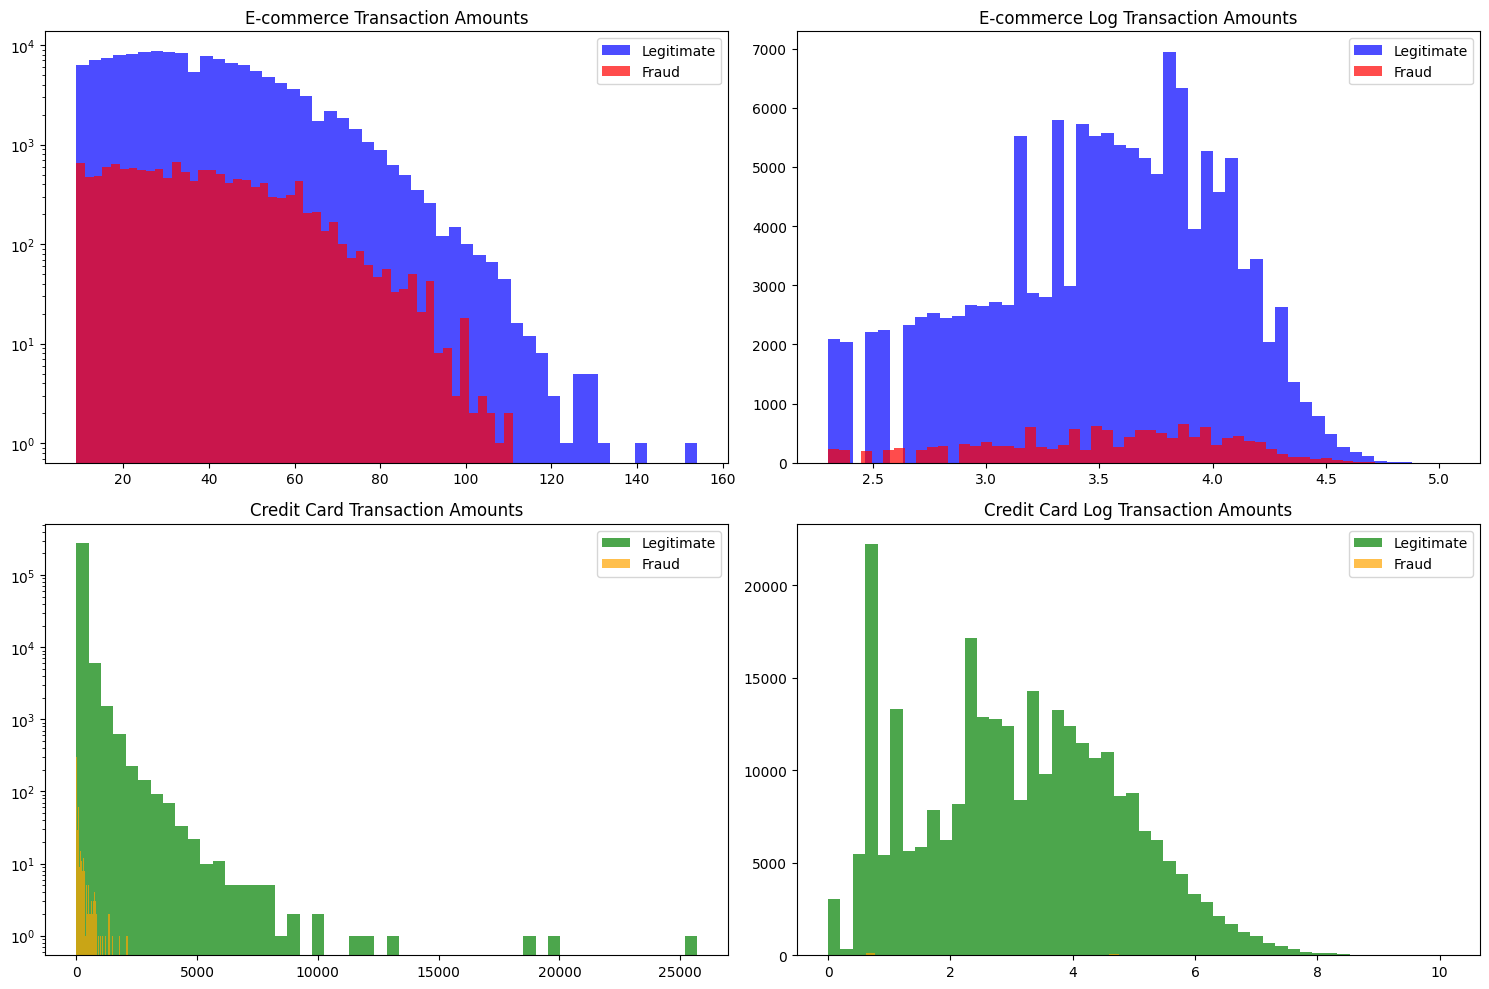

In [12]:
# Initialize analyzer
analyzer = FraudDataAnalyzer(fraud_data, creditcard_data)

# Run comprehensive analysis
analyzer.basic_info_analysis()
imbalance_info = analyzer.class_imbalance_analysis()
analyzer.feature_analysis()
analyzer.fraud_pattern_analysis()

### Data Preprocessing and Cleaning

In [13]:
class FraudDataPreprocessor:
    """Advanced data preprocessing for fraud detection"""

    def __init__(self):
        self.fraud_encoders = {}
        self.fraud_scalers = {}
        self.cc_scalers = {}

In [14]:
@add_method(FraudDataPreprocessor)
def clean_fraud_data(self, df):
    """Clean and preprocess fraud data"""
    print("Cleaning Fraud Data...")
    df_clean = df.copy()

    # Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows")

    # Data type corrections
    df_clean['signup_time'] = pd.to_datetime(df_clean['signup_time'])
    df_clean['purchase_time'] = pd.to_datetime(df_clean['purchase_time'])

    # Remove rows with invalid data
    initial_rows = len(df_clean)

    # Remove negative purchase values
    df_clean = df_clean[df_clean['purchase_value'] > 0]

    # Remove invalid ages
    df_clean = df_clean[(df_clean['age'] >= 18) & (df_clean['age'] <= 100)]

    # Remove future timestamps
    current_time = datetime.now()
    df_clean = df_clean[df_clean['purchase_time'] <= current_time]
    df_clean = df_clean[df_clean['signup_time'] <= current_time]

    print(f"Removed {initial_rows - len(df_clean)} invalid rows")
    print(f"Final dataset shape: {df_clean.shape}")

    return df_clean

In [15]:
@add_method(FraudDataPreprocessor)
def clean_creditcard_data(self, df):
    """Clean and preprocess credit card data"""
    print("Cleaning Credit Card Data...")
    df_clean = df.copy()

    # Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows")

    # Remove negative amounts
    initial_rows = len(df_clean)
    df_clean = df_clean[df_clean['Amount'] >= 0]

    print(f"Removed {initial_rows - len(df_clean)} invalid rows")
    print(f"Final dataset shape: {df_clean.shape}")

    return df_clean

In [16]:
@add_method(FraudDataPreprocessor)
def ip_to_country_mapping(self, ip_df, ip_address):
    """Convert IP address to country using the mapping dataset"""
    try:
        ip_int = int(ipaddress.IPv4Address(ip_address))

        # Find matching range
        country_row = ip_df[
            (ip_df['lower_bound_ip_address'] <= ip_int) &
            (ip_df['upper_bound_ip_address'] >= ip_int)
        ]

        return country_row['country'].iloc[0] if not country_row.empty else 'Unknown'
    except:
        return 'Unknown'

In [17]:
@add_method(FraudDataPreprocessor)
def advanced_feature_engineering(self, fraud_df, ip_country_df):
    """Create advanced features for fraud detection"""
    print("Advanced Feature Engineering...")
    df_featured = fraud_df.copy()

    # 1. Temporal Features
    print("Creating temporal features...")
    df_featured['signup_time'] = pd.to_datetime(df_featured['signup_time'])
    df_featured['purchase_time'] = pd.to_datetime(df_featured['purchase_time'])

    # Time differences
    df_featured['time_since_signup'] = (
        df_featured['purchase_time'] - df_featured['signup_time']
    ).dt.total_seconds() / 3600  # in hours

    # Time-based features
    df_featured['purchase_hour'] = df_featured['purchase_time'].dt.hour
    df_featured['purchase_day_of_week'] = df_featured['purchase_time'].dt.dayofweek
    df_featured['purchase_month'] = df_featured['purchase_time'].dt.month
    df_featured['signup_hour'] = df_featured['signup_time'].dt.hour
    df_featured['signup_day_of_week'] = df_featured['signup_time'].dt.dayofweek

    # Behavioral flags
    df_featured['immediate_purchase'] = (df_featured['time_since_signup'] < 1).astype(int)
    df_featured['same_day_purchase'] = (df_featured['time_since_signup'] < 24).astype(int)
    df_featured['weekend_purchase'] = df_featured['purchase_day_of_week'].isin([5, 6]).astype(int)
    df_featured['night_purchase'] = (
        (df_featured['purchase_hour'] >= 22) | (df_featured['purchase_hour'] <= 6)
    ).astype(int)

    # 2. Geolocation Features
    print("Creating geolocation features...")
    # Map IP addresses to countries (this might take a while)
    print("Mapping IP addresses to countries...")
    df_featured['country'] = df_featured['ip_address'].apply(
        lambda ip: self.ip_to_country_mapping(ip_country_df, ip)
    )

    # Country-based risk features
    country_fraud_rates = df_featured.groupby('country')['class'].mean()
    df_featured['country_fraud_rate'] = df_featured['country'].map(country_fraud_rates)
    df_featured['high_risk_country'] = (
        df_featured['country_fraud_rate'] > country_fraud_rates.quantile(0.8)
    ).astype(int)

    # 3. User Behavior Features
    print("Creating user behavior features...")
    user_stats = df_featured.groupby('user_id').agg({
        'purchase_value': ['count', 'sum', 'mean', 'std'],
        'device_id': 'nunique',
        'ip_address': 'nunique',
        'country': 'nunique',
        'browser': 'nunique',
        'source': 'nunique'
    })

    # Flatten column names
    user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns]
    user_stats.reset_index(inplace=True)

    # Merge back
    df_featured = df_featured.merge(user_stats, on='user_id', how='left')

    # User risk indicators
    df_featured['multiple_devices'] = (df_featured['device_id_nunique'] > 1).astype(int)
    df_featured['multiple_ips'] = (df_featured['ip_address_nunique'] > 1).astype(int)
    df_featured['multiple_countries'] = (df_featured['country_nunique'] > 1).astype(int)
    df_featured['multiple_browsers'] = (df_featured['browser_nunique'] > 1).astype(int)
    df_featured['multiple_sources'] = (df_featured['source_nunique'] > 1).astype(int)

    # 4. Device and Browser Intelligence
    print("Creating device/browser features...")
    # Browser fraud rates
    browser_fraud_rates = df_featured.groupby('browser')['class'].mean()
    df_featured['browser_fraud_rate'] = df_featured['browser'].map(browser_fraud_rates)

    # Source fraud rates
    source_fraud_rates = df_featured.groupby('source')['class'].mean()
    df_featured['source_fraud_rate'] = df_featured['source'].map(source_fraud_rates)

    # Device sharing analysis
    device_stats = df_featured.groupby('device_id').agg({
        'user_id': 'nunique',
        'class': 'mean'
    }).reset_index()
    device_stats.columns = ['device_id', 'users_per_device', 'device_fraud_rate']
    df_featured = df_featured.merge(device_stats, on='device_id', how='left')

    # 5. Transaction Amount Features
    print("Creating transaction amount features...")
    # Amount percentiles and z-scores
    df_featured['amount_percentile'] = df_featured['purchase_value'].rank(pct=True)
    df_featured['amount_zscore'] = (
        df_featured['purchase_value'] - df_featured['purchase_value'].mean()
    ) / df_featured['purchase_value'].std()

    # Amount flags
    df_featured['high_amount'] = (
        df_featured['purchase_value'] > df_featured['purchase_value'].quantile(0.95)
    ).astype(int)
    df_featured['low_amount'] = (
        df_featured['purchase_value'] < df_featured['purchase_value'].quantile(0.05)
    ).astype(int)
    df_featured['round_amount'] = (df_featured['purchase_value'] % 1 == 0).astype(int)

    # 6. Age and Gender Features
    print("Creating demographic features...")
    # Age groups
    df_featured['age_group'] = pd.cut(
        df_featured['age'],
        bins=[0, 25, 35, 50, 65, 100],
        labels=['18-25', '26-35', '36-50', '51-65', '65+']
    )

    # Gender-age interaction
    df_featured['gender_age_group'] = df_featured['sex'] + '_' + df_featured['age_group'].astype(str)

    print(f"Feature engineering completed. New shape: {df_featured.shape}")
    return df_featured

In [18]:
@add_method(FraudDataPreprocessor)
def encode_categorical_features(self, df, fit=True):
    """Encode categorical features"""
    print("Encoding categorical features...")
    df_encoded = df.copy()

    # Categorical columns to encode
    categorical_cols = ['browser', 'source', 'sex', 'country', 'age_group', 'gender_age_group']

    for col in categorical_cols:
        if col in df_encoded.columns:
            if fit:
                le = LabelEncoder()
                df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col].astype(str))
                self.fraud_encoders[col] = le
            else:
                if col in self.fraud_encoders:
                    # Handle unknown categories
                    le = self.fraud_encoders[col]
                    df_encoded[f'{col}_temp'] = df_encoded[col].astype(str)
                    mask = df_encoded[f'{col}_temp'].isin(le.classes_)
                    df_encoded[f'{col}_encoded'] = 0  # default value
                    df_encoded.loc[mask, f'{col}_encoded'] = le.transform(df_encoded.loc[mask, f'{col}_temp'])
                    df_encoded.drop(f'{col}_temp', axis=1, inplace=True)
                else:
                    df_encoded[f'{col}_encoded'] = 0

    return df_encoded

In [19]:
@add_method(FraudDataPreprocessor)
def scale_features(self, df, target_col='class', fit=True, dataset_type='fraud'):
    """Scale numerical features"""
    print(f"Scaling {dataset_type} features...")
    df_scaled = df.copy()

    # Select numerical columns (excluding target and ID columns)
    exclude_cols = [target_col, 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time']
    if dataset_type == 'creditcard':
        exclude_cols = [target_col]

    numerical_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

    if fit:
        scaler = StandardScaler()
        df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])
        if dataset_type == 'fraud':
            self.fraud_scalers['standard'] = scaler
        else:
            self.cc_scalers['standard'] = scaler
    else:
        if dataset_type == 'fraud' and 'standard' in self.fraud_scalers:
            scaler = self.fraud_scalers['standard']
            df_scaled[numerical_cols] = scaler.transform(df_scaled[numerical_cols])
        elif dataset_type == 'creditcard' and 'standard' in self.cc_scalers:
            scaler = self.cc_scalers['standard']
            df_scaled[numerical_cols] = scaler.transform(df_scaled[numerical_cols])

    return df_scaled, numerical_cols

In [20]:
# Initialize preprocessor
preprocessor = FraudDataPreprocessor()

# Clean datasets
print("=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

fraud_data_clean = preprocessor.clean_fraud_data(fraud_data)
creditcard_data_clean = preprocessor.clean_creditcard_data(creditcard_data)

# Feature engineering for fraud data
fraud_data_featured = preprocessor.advanced_feature_engineering(fraud_data_clean, ip_country)

# Encode categorical features
fraud_data_encoded = preprocessor.encode_categorical_features(fraud_data_featured, fit=True)

print(f"\n Preprocessing completed!")
print(f"Fraud data final shape: {fraud_data_encoded.shape}")
print(f"Credit card data final shape: {creditcard_data_clean.shape}")


DATA PREPROCESSING
Cleaning Fraud Data...
Missing values before cleaning: 0
Removed 0 invalid rows
Final dataset shape: (151112, 11)
Cleaning Credit Card Data...
Missing values before cleaning: 0
Removed 1081 duplicate rows
Removed 0 invalid rows
Final dataset shape: (283726, 31)
Advanced Feature Engineering...
Creating temporal features...
Creating geolocation features...
Mapping IP addresses to countries...
Creating user behavior features...
Creating device/browser features...
Creating transaction amount features...
Creating demographic features...
Feature engineering completed. New shape: (151112, 49)
Encoding categorical features...

 Preprocessing completed!
Fraud data final shape: (151112, 55)
Credit card data final shape: (283726, 31)


### Class Imbalance Handling

In [21]:
class ImbalanceHandler:
    """Advanced class imbalance handling techniques"""

    def __init__(self):
        self.samplers = {
            'smote': SMOTE(random_state=42, k_neighbors=3),
            'adasyn': ADASYN(random_state=42),
            'borderline_smote': BorderlineSMOTE(random_state=42, kind='borderline-1'),
            'smote_tomek': SMOTETomek(random_state=42)
        }

    def analyze_imbalance(self, y, dataset_name):
        """Comprehensive imbalance analysis"""
        print(f"\n{dataset_name.upper()} IMBALANCE ANALYSIS:")
        counter = Counter(y)
        majority_class = max(counter, key=counter.get)
        minority_class = min(counter, key=counter.get)

        imbalance_ratio = counter[majority_class] / counter[minority_class]
        minority_percentage = (counter[minority_class] / sum(counter.values())) * 100

        print(f"Class Distribution: {counter}")
        print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
        print(f"Minority Class Percentage: {minority_percentage:.4f}%")

        # Recommend strategies based on imbalance severity
        if imbalance_ratio > 100:
            print("SEVERE IMBALANCE: Recommend ensemble methods + advanced resampling")
            recommended_techniques = ['smote', 'adasyn', 'smote_tomek']
        elif imbalance_ratio > 10:
            print("MODERATE IMBALANCE: Recommend SMOTE + cost-sensitive learning")
            recommended_techniques = ['smote', 'borderline_smote']
        else:
            print("MILD IMBALANCE: Class weights may be sufficient")
            recommended_techniques = ['class_weights']

        return {
            'imbalance_ratio': imbalance_ratio,
            'minority_percentage': minority_percentage,
            'recommended_techniques': recommended_techniques,
            'counter': counter
        }

    def apply_resampling(self, X, y, method='smote'):
        """Apply selected resampling method"""
        print(f"Applying {method.upper()} resampling...")

        original_counter = Counter(y)
        print(f"Original distribution: {original_counter}")

        if method in self.samplers:
            try:
                sampler = self.samplers[method]
                X_resampled, y_resampled = sampler.fit_resample(X, y)

                resampled_counter = Counter(y_resampled)
                print(f"Resampled distribution: {resampled_counter}")
                print(f"Samples added: {len(y_resampled) - len(y)} ({(len(y_resampled) - len(y))/len(y)*100:.1f}% increase)")

                return X_resampled, y_resampled

            except Exception as e:
                print(f"Error applying {method}: {e}")
                print("Returning original data...")
                return X, y
        else:
            print(f"Unknown resampling method: {method}")
            return X, y

    def compare_resampling_methods(self, X, y, methods=None):
        """Compare different resampling methods"""
        if methods is None:
            methods = list(self.samplers.keys())

        results = {}
        original_size = len(y)
        original_counter = Counter(y)

        print(f"\nCOMPARING RESAMPLING METHODS:")
        print(f"Original size: {original_size}")
        print(f"Original distribution: {original_counter}")

        for method in methods:
            print(f"\n--- {method.upper()} ---")
            try:
                X_res, y_res = self.apply_resampling(X, y, method)
                results[method] = {
                    'original_size': original_size,
                    'resampled_size': len(y_res),
                    'size_increase': len(y_res) - original_size,
                    'size_increase_pct': ((len(y_res) - original_size) / original_size) * 100,
                    'final_distribution': Counter(y_res),
                    'balance_ratio': Counter(y_res)[0] / Counter(y_res)[1]
                }
            except Exception as e:
                results[method] = {'error': str(e)}

        return results

    def calculate_class_weights(self, y):
        """Calculate optimal class weights for cost-sensitive learning"""
        from sklearn.utils.class_weight import compute_class_weight

        classes = np.unique(y)
        weights = compute_class_weight('balanced', classes=classes, y=y)
        class_weight_dict = dict(zip(classes, weights))

        print(f"Calculated class weights: {class_weight_dict}")
        return class_weight_dict

In [22]:
# Initialize imbalance handler
imbalance_handler = ImbalanceHandler()

# Analyze imbalance in both datasets
print("=" * 80)
print("CLASS IMBALANCE HANDLING")
print("=" * 80)

# Prepare features for imbalance analysis
# Fraud data features
fraud_feature_cols = [col for col in fraud_data_encoded.columns
                     if col not in ['user_id', 'device_id', 'ip_address', 'signup_time',
                                   'purchase_time', 'class', 'browser', 'source', 'sex',
                                   'country', 'age_group', 'gender_age_group']]

X_fraud = fraud_data_encoded[fraud_feature_cols]
y_fraud = fraud_data_encoded['class']

# Credit card features
X_creditcard = creditcard_data_clean.drop('Class', axis=1)
y_creditcard = creditcard_data_clean['Class']

# Analyze imbalance
fraud_imbalance_info = imbalance_handler.analyze_imbalance(y_fraud, "E-commerce Fraud")
cc_imbalance_info = imbalance_handler.analyze_imbalance(y_creditcard, "Credit Card")

# Calculate class weights for both datasets
fraud_class_weights = imbalance_handler.calculate_class_weights(y_fraud)
cc_class_weights = imbalance_handler.calculate_class_weights(y_creditcard)

# Check for NaNs in the feature engineered data before splitting
print("\nChecking for NaNs in feature engineered data...")
print(f"NaNs in fraud_data_encoded: {fraud_data_encoded.isnull().sum().sum()}")
print(f"NaNs in creditcard_data_clean: {creditcard_data_clean.isnull().sum().sum()}")

# Handle NaNs after feature engineering and before scaling
# For simplicity, we'll fill NaNs with the mean of numerical columns. More sophisticated imputation can be used.
print("\nHandling NaNs by filling with mean of numerical columns...")
fraud_data_encoded[fraud_data_encoded.select_dtypes(include=np.number).columns] = fraud_data_encoded.select_dtypes(include=np.number).fillna(fraud_data_encoded.select_dtypes(include=np.number).mean())
creditcard_data_clean[creditcard_data_clean.select_dtypes(include=np.number).columns] = creditcard_data_clean.select_dtypes(include=np.number).fillna(creditcard_data_clean.select_dtypes(include=np.number).mean())


print(f"NaNs after filling for fraud_data_encoded: {fraud_data_encoded.isnull().sum().sum()}")
print(f"NaNs after filling for creditcard_data_clean: {creditcard_data_clean.isnull().sum().sum()}")

CLASS IMBALANCE HANDLING

E-COMMERCE FRAUD IMBALANCE ANALYSIS:
Class Distribution: Counter({0: 136961, 1: 14151})
Imbalance Ratio: 9.68:1
Minority Class Percentage: 9.3646%
MILD IMBALANCE: Class weights may be sufficient

CREDIT CARD IMBALANCE ANALYSIS:
Class Distribution: Counter({0: 283253, 1: 473})
Imbalance Ratio: 598.84:1
Minority Class Percentage: 0.1667%
SEVERE IMBALANCE: Recommend ensemble methods + advanced resampling
Calculated class weights: {np.int64(0): np.float64(0.5516606917297625), np.int64(1): np.float64(5.339269309589429)}
Calculated class weights: {np.int64(0): np.float64(0.5008349426131409), np.int64(1): np.float64(299.9217758985201)}

Checking for NaNs in feature engineered data...
NaNs in fraud_data_encoded: 151112
NaNs in creditcard_data_clean: 0

Handling NaNs by filling with mean of numerical columns...
NaNs after filling for fraud_data_encoded: 151112
NaNs after filling for creditcard_data_clean: 0


### Train-Test Split and Data Preparation

In [23]:
print("\n" + "=" * 80)
print("TRAIN-TEST SPLIT AND DATA PREPARATION")
print("=" * 80)

# Scale features before splitting
fraud_data_scaled, fraud_numerical_cols = preprocessor.scale_features(
    fraud_data_encoded, target_col='class', fit=True, dataset_type='fraud'
)

cc_data_scaled, cc_numerical_cols = preprocessor.scale_features(
    creditcard_data_clean, target_col='Class', fit=True, dataset_type='creditcard'
)

# Prepare final feature sets
X_fraud_final = fraud_data_scaled[fraud_feature_cols]
y_fraud_final = fraud_data_scaled['class']

X_cc_final = cc_data_scaled.drop('Class', axis=1)
y_cc_final = cc_data_scaled['Class']

print("Final feature dimensions:")
print(f"E-commerce fraud: {X_fraud_final.shape}")
print(f"Credit card: {X_cc_final.shape}")

# Stratified train-test split
print("\nPerforming stratified train-test split...")

# Fraud data split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud_final, y_fraud_final,
    test_size=0.2,
    random_state=42,
    stratify=y_fraud_final
)

# Credit card split
X_cc_train, X_cc_test, y_cc_train, y_cc_test = train_test_split(
    X_cc_final, y_cc_final,
    test_size=0.2,
    random_state=42,
    stratify=y_cc_final
)

print("Train-test split completed:")
print(f"E-commerce - Train: {X_fraud_train.shape}, Test: {X_fraud_test.shape}")
print(f"Credit card - Train: {X_cc_train.shape}, Test: {X_cc_test.shape}")

# Verify class distribution is maintained
print("\nClass distribution verification:")
print(f"E-commerce train: {Counter(y_fraud_train)}")
print(f"E-commerce test: {Counter(y_fraud_test)}")
print(f"Credit card train: {Counter(y_cc_train)}")
print(f"Credit card test: {Counter(y_cc_test)}")

# Apply resampling to training data only
print("\nApplying SMOTE resampling to training data...")

# Apply SMOTE to fraud training data
X_fraud_train_balanced, y_fraud_train_balanced = imbalance_handler.apply_resampling(
    X_fraud_train, y_fraud_train, method='smote'
)

# Apply SMOTE to credit card training data
X_cc_train_balanced, y_cc_train_balanced = imbalance_handler.apply_resampling(
    X_cc_train, y_cc_train, method='smote'
)

print("Resampling completed!")


TRAIN-TEST SPLIT AND DATA PREPARATION
Scaling fraud features...
Scaling creditcard features...
Final feature dimensions:
E-commerce fraud: (151112, 43)
Credit card: (283726, 30)

Performing stratified train-test split...
Train-test split completed:
E-commerce - Train: (120889, 43), Test: (30223, 43)
Credit card - Train: (226980, 30), Test: (56746, 30)

Class distribution verification:
E-commerce train: Counter({0: 109568, 1: 11321})
E-commerce test: Counter({0: 27393, 1: 2830})
Credit card train: Counter({0: 226602, 1: 378})
Credit card test: Counter({0: 56651, 1: 95})

Applying SMOTE resampling to training data...
Applying SMOTE resampling...
Original distribution: Counter({0: 109568, 1: 11321})
Error applying smote: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it i

### Model Training and Evaluation

In [28]:
class FraudModelTrainer:
    """Fraud detection model training and evaluation with RandomForest & XGBoost only"""

    def __init__(self):
        self.models = {}
        self.results = {}

    def create_models(self, class_weights=None):
        """Create RandomForest and XGBoost models"""
        models = {}

        # 1. Random Forest
        models['random_forest'] = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight=class_weights,
            n_jobs=-1
        )

        # 2. XGBoost
        if class_weights:
            scale_pos_weight = class_weights[1] / class_weights[0]
        else:
            scale_pos_weight = 1

        models['xgboost'] = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='aucpr',
            use_label_encoder=False
        )

        return models

    def train_models(self, X_train, y_train, dataset_name, class_weights=None):
        """Train RandomForest and XGBoost on given dataset"""
        print(f"\nTraining models on {dataset_name} dataset...")

        models = self.create_models(class_weights)
        trained_models = {}

        for name, model in models.items():
            print(f"Training {name}...")
            try:
                model.fit(X_train, y_train)
                trained_models[name] = model
                print(f"{name} trained successfully")
            except Exception as e:
                print(f"Error training {name}: {e}")

        self.models[dataset_name] = trained_models
        return trained_models

    def calculate_fraud_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate comprehensive fraud detection metrics"""
        from sklearn.metrics import (precision_score, recall_score, f1_score,
                                    accuracy_score, matthews_corrcoef)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_pred_proba),
            'pr_auc': average_precision_score(y_true, y_pred_proba),
            'mcc': matthews_corrcoef(y_true, y_pred)
        }

        return metrics

    def evaluate_models(self, X_test, y_test, dataset_name):
        """Evaluate trained models"""
        print(f"\nEvaluating models on {dataset_name} dataset...")

        if dataset_name not in self.models:
            print(f"No trained models found for {dataset_name}")
            return None

        results = {}
        trained_models = self.models[dataset_name]

        for name, model in trained_models.items():
            print(f"Evaluating {name}...")

            try:
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]

                metrics = self.calculate_fraud_metrics(y_test, y_pred, y_pred_proba)
                cm = confusion_matrix(y_test, y_pred)

                results[name] = {
                    'metrics': metrics,
                    'confusion_matrix': cm,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba
                }

                print(f"{name} evaluated - F1: {metrics['f1_score']:.4f}, AUC-PR: {metrics['pr_auc']:.4f}")

            except Exception as e:
                print(f"Error evaluating {name}: {e}")

        self.results[dataset_name] = results
        return results

    def print_results_summary(self, dataset_name):
        """Print summary of results"""
        if dataset_name not in self.results:
            print(f"No results found for {dataset_name}")
            return

        results = self.results[dataset_name]
        print(f"\n{dataset_name.upper()} RESULTS SUMMARY:")
        print("=" * 80)

        metrics_df = pd.DataFrame({
            model_name: result['metrics']
            for model_name, result in results.items()
        }).T

        metrics_df = metrics_df.sort_values('f1_score', ascending=False)
        print(metrics_df.round(4))

        best_model = metrics_df.index[0]
        print(f"\nBest performing model: {best_model}")
        print(f"F1-Score: {metrics_df.loc[best_model, 'f1_score']:.4f}")
        print(f"Precision: {metrics_df.loc[best_model, 'precision']:.4f}")
        print(f"Recall: {metrics_df.loc[best_model, 'recall']:.4f}")
        print(f"AUC-PR: {metrics_df.loc[best_model, 'pr_auc']:.4f}")

        return best_model, metrics_df

    def plot_confusion_matrices(self, dataset_name):
        """Plot confusion matrices for all models"""
        if dataset_name not in self.results:
            return

        results = self.results[dataset_name]
        n_models = len(results)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        for idx, (name, result) in enumerate(results.items()):
            if idx < len(axes):
                cm = result['confusion_matrix']
                sns.heatmap(
                    cm,
                    annot=True,
                    fmt='d',
                    ax=axes[idx],
                    cmap='Blues',
                    cbar=False
                )
                axes[idx].set_title(f'{name} - Confusion Matrix')
                axes[idx].set_xlabel('Predicted')
                axes[idx].set_ylabel('Actual')

        # Hide unused subplots
        for idx in range(len(results), len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle(f'{dataset_name.upper()} - Confusion Matrices')
        plt.tight_layout()
        plt.show()

    def plot_roc_pr_curves(self, X_test, y_test, dataset_name):
        """Plot ROC and Precision-Recall curves"""
        if dataset_name not in self.results:
            return

        results = self.results[dataset_name]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # ROC Curves
        for name, result in results.items():
            y_pred_proba = result['y_pred_proba']

            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = result['metrics']['roc_auc']
            ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

            # PR curve
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = result['metrics']['pr_auc']
            ax2.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

        # ROC plot formatting
        ax1.plot([0, 1], [0, 1], 'k--', label='Random')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'{dataset_name.upper()} - ROC Curves')
        ax1.legend()
        ax1.grid(True)

        # PR plot formatting
        baseline_precision = Counter(y_test)[1] / len(y_test)
        ax2.axhline(y=baseline_precision, color='k', linestyle='--', label=f'Baseline ({baseline_precision:.3f})')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title(f'{dataset_name.upper()} - Precision-Recall Curves')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()


Handling NaNs in resampled fraud training data...
NaNs in X_fraud_train_balanced after filling: 120889

Training models on fraud_data dataset...
Training random_forest...
random_forest trained successfully
Training xgboost...
xgboost trained successfully

Training models on credit_card dataset...
Training random_forest...
random_forest trained successfully
Training xgboost...
xgboost trained successfully

Evaluating models on fraud_data dataset...
Evaluating random_forest...
random_forest evaluated - F1: 0.9328, AUC-PR: 0.9622
Evaluating xgboost...
xgboost evaluated - F1: 0.9331, AUC-PR: 0.9904

Evaluating models on credit_card dataset...
Evaluating random_forest...
random_forest evaluated - F1: 0.0051, AUC-PR: 0.5408
Evaluating xgboost...
xgboost evaluated - F1: 0.1176, AUC-PR: 0.7511

FRAUD_DATA RESULTS SUMMARY:
               accuracy  precision  recall  f1_score  roc_auc  pr_auc     mcc
xgboost          0.9866     0.8760  0.9982    0.9331   0.9990  0.9904  0.9281
random_forest    

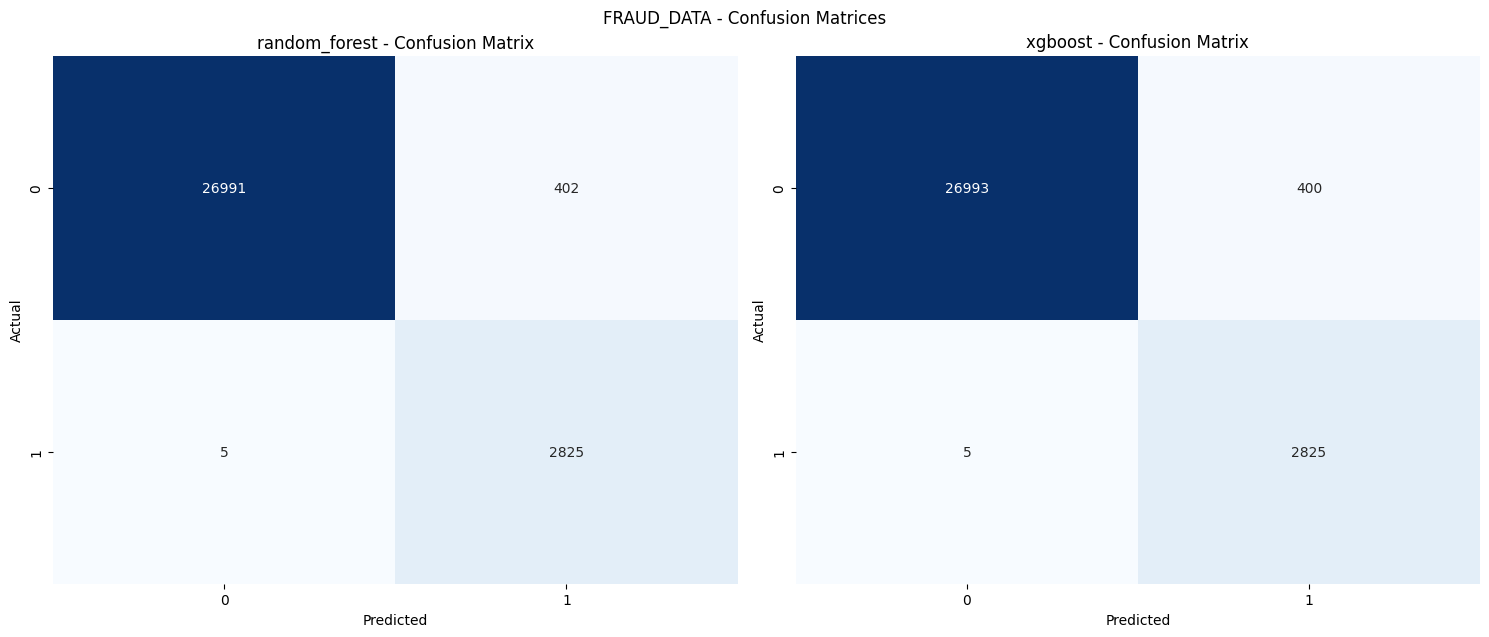

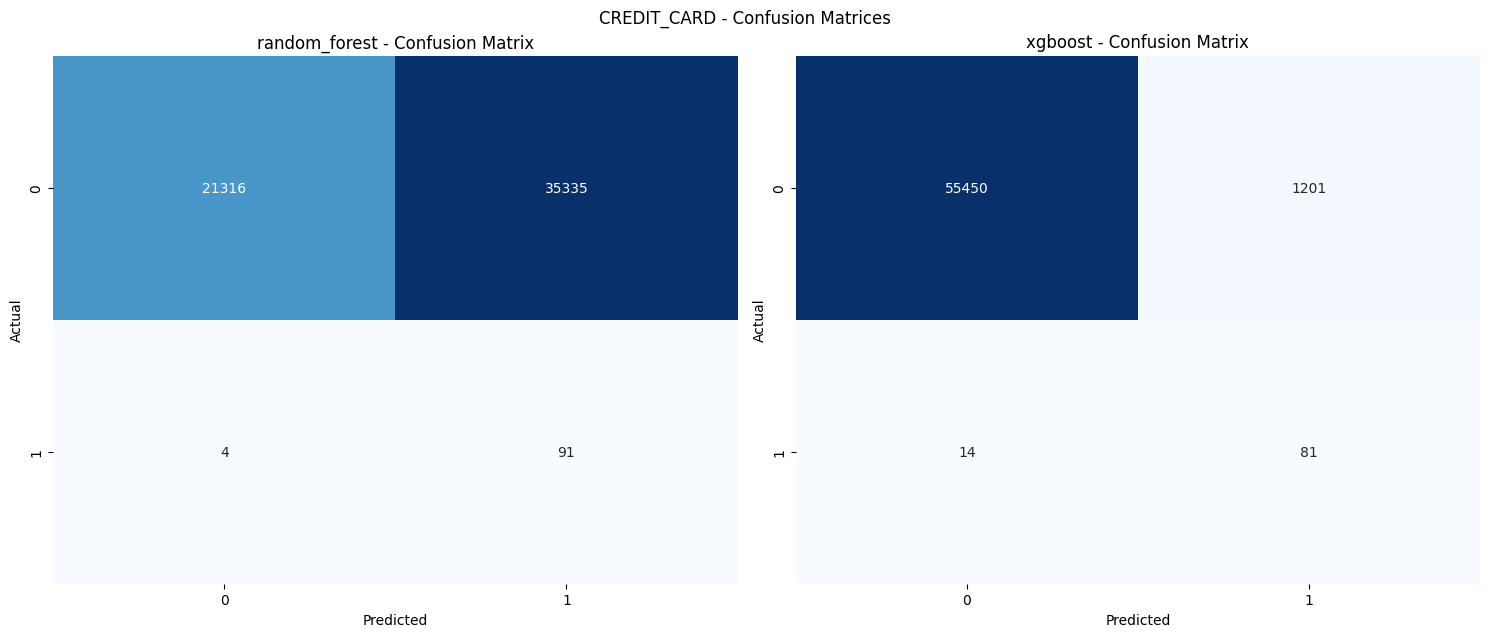

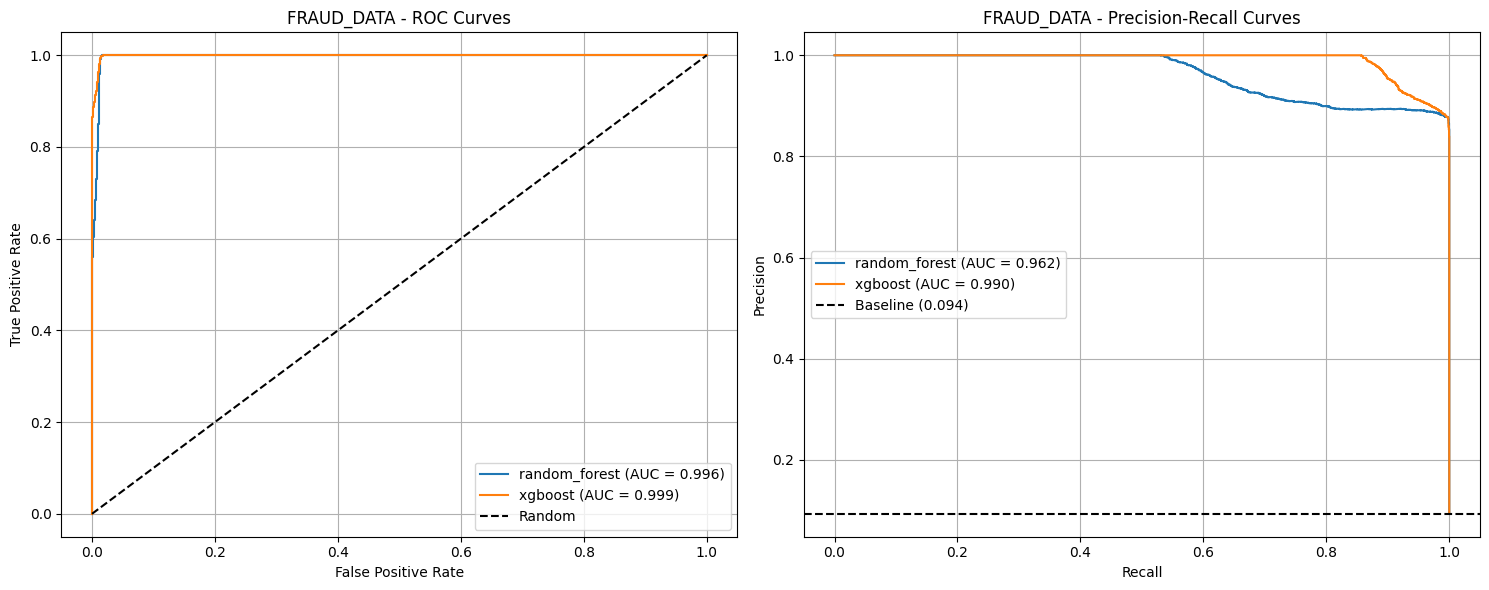

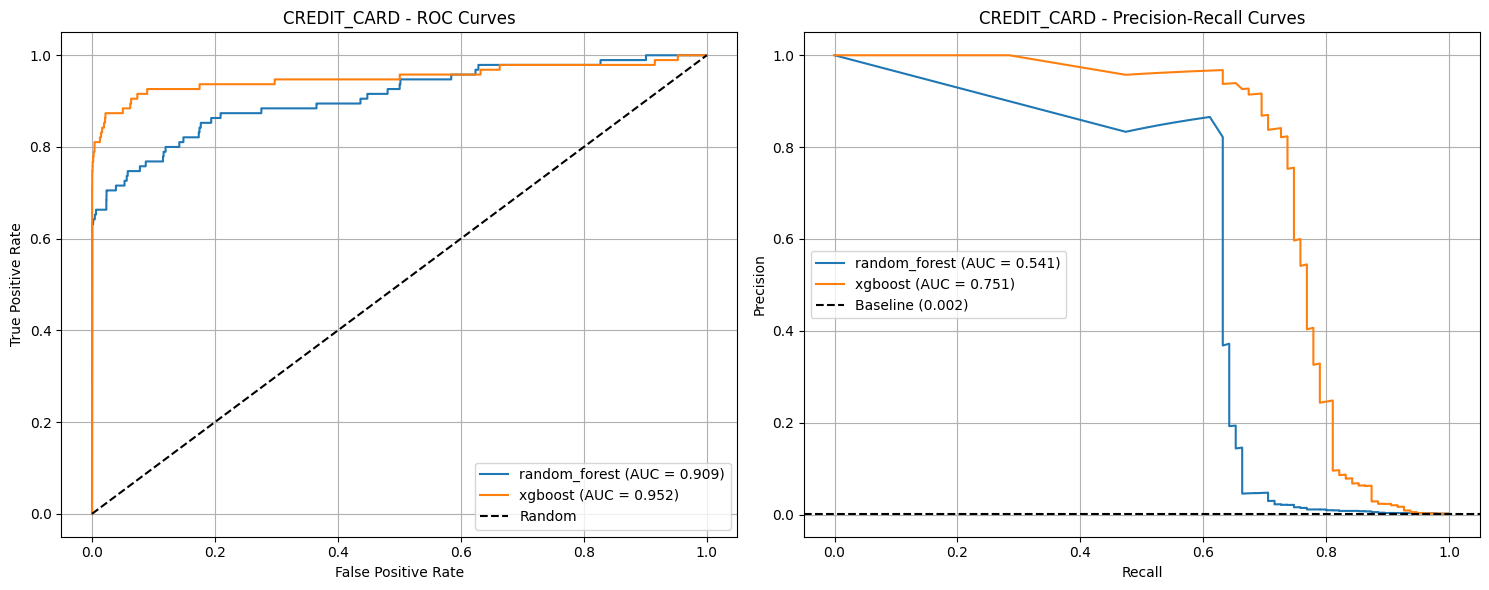

In [29]:
# Initialize model trainer
trainer = FraudModelTrainer()

# Handle NaNs in the resampled training data for fraud data
print("\nHandling NaNs in resampled fraud training data...")
X_fraud_train_balanced.fillna(X_fraud_train_balanced.mean(), inplace=True)
print(f"NaNs in X_fraud_train_balanced after filling: {X_fraud_train_balanced.isnull().sum().sum()}")

# Train models on fraud data
fraud_models = trainer.train_models(
    X_fraud_train_balanced, y_fraud_train_balanced,
    'fraud_data', fraud_class_weights
)

# Train models on credit card data
cc_models = trainer.train_models(
    X_cc_train_balanced, y_cc_train_balanced,
    'credit_card', cc_class_weights
)

# Evaluate models
fraud_results = trainer.evaluate_models(X_fraud_test, y_fraud_test, 'fraud_data')
cc_results = trainer.evaluate_models(X_cc_test, y_cc_test, 'credit_card')

# Print results summaries
fraud_best_model, fraud_metrics_df = trainer.print_results_summary('fraud_data')
cc_best_model, cc_metrics_df = trainer.print_results_summary('credit_card')

# Plot evaluation visualizations
trainer.plot_confusion_matrices('fraud_data')
trainer.plot_confusion_matrices('credit_card')

trainer.plot_roc_pr_curves(X_fraud_test, y_fraud_test, 'fraud_data')
trainer.plot_roc_pr_curves(X_cc_test, y_cc_test, 'credit_card')


### EXPLAINABLE AI (XAI) IMPLEMENTATION

In [30]:
!pip install -q shap imbalanced-learn xgboost lightgbm plotly kaleido
!pip install -q ipywidgets widgetsnbextension

In [31]:
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap
from collections import OrderedDict
from typing import Optional, Tuple, Dict, Any

# Configure Plotly for Colab
pio.renderers.default = "colab"

# Initialize SHAP JavaScript for interactive plots
shap.initjs()

In [32]:
try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

In [46]:

class AdvancedSHAPExplainer:
    """
    Compact, robust SHAP explainer utility.
    - Prefer TreeExplainer for tree models (RandomForest, XGBoost)
    - Caches explainers and computed shap values
    """
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        self.explainers: Dict[str, Any] = {}
        self.background: Dict[str, pd.DataFrame] = {}
        self.cache: Dict[str, Dict[str, Any]] = {}  # holds shap_values, X_sample, expected_value
        self.feature_names: Dict[str, list] = {}

    def init_explainer(self, model, X_train: pd.DataFrame, feature_names: list,
                       dataset_name: str, background_size: int = 200) -> bool:
        """Create & cache explainer for a model + dataset. Returns True on success."""
        self.feature_names[dataset_name] = feature_names
        if len(X_train) > background_size:
            bg = X_train.sample(background_size, random_state=self.random_state)
        else:
            bg = X_train.copy()
        self.background[dataset_name] = bg

        # Prefer TreeExplainer for tree models
        model_type = type(model).__name__.lower()
        try:
            if any(k in model_type for k in ("randomforest", "xgb", "xgboost", "lgb", "gradientboosting", "catboost")):
                expl = shap.TreeExplainer(model, data=bg, feature_perturbation="interventional")
            else:
                # shap.Explainer will choose appropriate explainer for many sklearn models
                expl = shap.Explainer(model.predict_proba if hasattr(model, "predict_proba") else model, bg)
            self.explainers[dataset_name] = expl
            return True
        except Exception as e:
            print(f"[SHAP] Failed to initialize explainer for {dataset_name}: {e}")
            try:
                # last-resort fallback
                expl = shap.Explainer(model.predict_proba if hasattr(model, "predict_proba") else model, bg)
                self.explainers[dataset_name] = expl
                return True
            except Exception as e2:
                print(f"[SHAP] Fallback explainer failed: {e2}")
                return False

    def compute_shap(self, dataset_name: str, X_data: pd.DataFrame,
                     max_samples: int = 500) -> Tuple[Optional[np.ndarray], Optional[pd.DataFrame], Optional[float]]:
        """
        Compute and cache SHAP values for X_data (or a sample if large).
        Returns (shap_values, X_sample, expected_value) or (None, None, None).
        shap_values will be an (n_samples, n_features) array for binary/real-valued explanations.
        """
        if dataset_name not in self.explainers:
            print(f"[SHAP] No explainer for {dataset_name}. Call init_explainer first.")
            return None, None, None

        X_sample = X_data.sample(n=min(len(X_data), max_samples), random_state=self.random_state) \
                   if len(X_data) > max_samples else X_data.copy()

        expl = self.explainers[dataset_name]
        try:
            # Two common SHAP APIs:
            # - older: expl.shap_values(X) -> array or list-of-arrays
            # - newer: expl(X) -> Explanation with .values and .base_values
            if hasattr(expl, "shap_values"):
                raw = expl.shap_values(X_sample)
                # If list-of-arrays (multiclass), prefer positive class (index 1) if available
                if isinstance(raw, list) and len(raw) >= 2:
                    shap_vals = np.asarray(raw[1])
                else:
                    shap_vals = np.asarray(raw)
                expected = getattr(expl, "expected_value", None)
                if isinstance(expected, (list, tuple, np.ndarray)) and len(expected) >= 2:
                    expected = float(expected[1])
                elif np.size(expected) > 1:
                    expected = float(np.asarray(expected).ravel()[0])
            else:
                ex = expl(X_sample)
                # ex.values shape could be (n, m) or (n, m, k) for multiclass
                vals = np.asarray(ex.values)
                if vals.ndim == 3:  # multiclass: (n, m, k)
                    # choose positive class index 1 if exists otherwise last
                    k = vals.shape[2]
                    cls_idx = 1 if k > 1 else 0
                    shap_vals = vals[:, :, cls_idx]
                else:
                    shap_vals = vals
                base = ex.base_values
                if isinstance(base, (list, tuple, np.ndarray)):
                    base = np.asarray(base)
                    expected = float(base.ravel()[0])
                else:
                    expected = float(base)
            # cache
            self.cache[dataset_name] = {
                "shap_values": shap_vals,
                "X_sample": X_sample,
                "expected_value": expected
            }
            print(f"[SHAP] Computed SHAP for {dataset_name}: {shap_vals.shape}")
            return shap_vals, X_sample, expected
        except Exception as e:
            print(f"[SHAP] Error computing SHAP for {dataset_name}: {e}")
            return None, None, None

    def plot_summary(self, dataset_name: str, top_n: int = 20, show_plotly: bool = True):
        """Plot SHAP summary (beeswarm) and bar plot of mean |SHAP|. Plotly bar optional."""
        entry = self.cache.get(dataset_name)
        if not entry:
            print(f"[SHAP] No cached SHAP values for {dataset_name}. Run compute_shap first.")
            return

        shap_vals = entry["shap_values"]
        X_sample = entry["X_sample"]
        feature_names = self.feature_names.get(dataset_name, X_sample.columns.tolist())

        # Summary beeswarm
        plt.figure(figsize=(10, 6))
        try:
            shap.summary_plot(shap_vals, X_sample, feature_names=feature_names, max_display=top_n, show=False)
            plt.title(f"{dataset_name.upper()} - SHAP Summary (beeswarm)")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"[SHAP] Summary plot error: {e}")

        # Bar (mean abs)
        mean_abs = np.abs(shap_vals).mean(axis=0)
        fi = pd.DataFrame({"feature": feature_names[:len(mean_abs)], "importance": mean_abs}).sort_values("importance", ascending=False).head(top_n)
        plt.figure(figsize=(8, max(4, 0.25 * len(fi))))
        plt.barh(fi["feature"][::-1], fi["importance"][::-1])
        plt.xlabel("Mean |SHAP value|")
        plt.title(f"{dataset_name.upper()} - Mean |SHAP| Feature Importance")
        plt.tight_layout()
        plt.show()

        # Optional interactive bar
        if show_plotly and PLOTLY_AVAILABLE:
            fig = go.Figure(go.Bar(
                x=fi["importance"][::-1],
                y=fi["feature"][::-1],
                orientation="h",
                text=[f"{v:.4f}" for v in fi["importance"][::-1]],
                textposition="auto"
            ))
            fig.update_layout(height=500, title=f"{dataset_name.upper()} - Interactive SHAP Importance")
            fig.show()

    def explain_instance(self, dataset_name: str, model, X_instance: pd.DataFrame, return_dict: bool = True):
        """
        Explain a single instance (DataFrame with 1 row).
        Returns a dictionary with:
            - prediction_proba, prediction_class, expected_value, shap_values (1d), top_features list
        Also plots a simple waterfall barh of top contributors.
        """
        if dataset_name not in self.explainers:
            print(f"[SHAP] No explainer for {dataset_name}.")
            return None

        if X_instance.shape[0] != 1:
            raise ValueError("X_instance must contain exactly 1 row.")

        expl = self.explainers[dataset_name]
        feat_names = self.feature_names.get(dataset_name, X_instance.columns.tolist())

        # model prediction
        pred_proba = model.predict_proba(X_instance)[0] if hasattr(model, "predict_proba") else None
        pred_class = model.predict(X_instance)[0] if hasattr(model, "predict") else None

        # get SHAP values for the instance
        try:
            if hasattr(expl, "shap_values"):
                raw = expl.shap_values(X_instance)
                if isinstance(raw, list) and len(raw) >= 2:
                    sv = np.asarray(raw[1])[0]
                else:
                    sv = np.asarray(raw)[0]
                expected = getattr(expl, "expected_value", None)
                if isinstance(expected, (list, tuple, np.ndarray)):
                    expected = float(np.asarray(expected).ravel()[0])
            else:
                out = expl(X_instance)
                vals = np.asarray(out.values)
                if vals.ndim == 3:
                    cls_idx = 1 if vals.shape[2] > 1 else 0
                    sv = vals[0, :, cls_idx]
                else:
                    sv = vals[0]
                base = out.base_values
                expected = float(np.asarray(base).ravel()[0])
        except Exception as e:
            print(f"[SHAP] Error obtaining instance SHAP: {e}")
            return None

        # top contributors
        idx_order = np.argsort(np.abs(sv))[::-1]
        top_idx = idx_order[:10]
        top_features = [(feat_names[i], float(sv[i]), float(X_instance.iloc[0, i])) for i in top_idx]

        # simple waterfall-like bar plot
        labels = [f"{f}\n(value: {v:.3f})" for f, _, v in top_features[::-1]]
        values = [s for _, s, _ in top_features[::-1]]
        colors = ["red" if v > 0 else "blue" for v in values]

        plt.figure(figsize=(8, max(3, 0.3 * len(values))))
        plt.barh(labels, values, color=colors, alpha=0.8)
        plt.xlabel("SHAP value (impact on positive class)")
        plt.title("Top feature contributions (waterfall-like)")
        plt.axvline(0, color="k", linewidth=0.8)
        plt.tight_layout()
        plt.show()

        result = {
            "prediction_proba": pred_proba,
            "prediction_class": pred_class,
            "expected_value": expected,
            "shap_values": sv,
            "top_features": top_features
        }
        return result if return_dict else None
    def plot_dependency(self, dataset_name: str, feature: str, interaction: Optional[str] = None):
        """SHAP dependency plot for a given feature (optionally colored by another)."""
        entry = self.cache.get(dataset_name)
        if not entry:
            print(f"[SHAP] No cached SHAP values for {dataset_name}. Run compute_shap first.")
            return

        shap_vals = entry["shap_values"]
        X_sample = entry["X_sample"]

        try:
            shap.dependence_plot(
                feature,
                shap_vals,
                X_sample,
                interaction_index=interaction,
                show=True
            )
        except Exception as e:
            print(f"[SHAP] Dependency plot error: {e}")

    def plot_force(self, dataset_name: str, idx: int = 0):
        """Force plot for a single instance (JS-based or static matplotlib)."""
        entry = self.cache.get(dataset_name)
        if not entry:
            print(f"[SHAP] No cached SHAP values for {dataset_name}. Run compute_shap first.")
            return

        shap_vals = entry["shap_values"]
        X_sample = entry["X_sample"]
        expected = entry["expected_value"]

        try:
            # Force plot (works in notebooks; can also be saved to HTML)
            plt.figure(figsize=(18, 4))  # make it wider
            shap.force_plot(
                expected,
                shap_vals[idx, :],
                X_sample.iloc[idx, :],
                matplotlib=True
            )
            plt.show()
        except Exception as e:
            print(f"[SHAP] Force plot error: {e}")

    def explain_instance(self, dataset_name: str, model, X_instance: pd.DataFrame, return_dict: bool = True):
        """
        Explain a single instance without custom waterfall-like bar.
        Use plot_force() if visualization is needed.
        """
        if dataset_name not in self.explainers:
            print(f"[SHAP] No explainer for {dataset_name}.")
            return None

        if X_instance.shape[0] != 1:
            raise ValueError("X_instance must contain exactly 1 row.")

        expl = self.explainers[dataset_name]
        feat_names = self.feature_names.get(dataset_name, X_instance.columns.tolist())

        pred_proba = model.predict_proba(X_instance)[0] if hasattr(model, "predict_proba") else None
        pred_class = model.predict(X_instance)[0] if hasattr(model, "predict") else None

        # get SHAP values for the instance
        try:
            if hasattr(expl, "shap_values"):
                raw = expl.shap_values(X_instance)
                if isinstance(raw, list) and len(raw) >= 2:
                    sv = np.asarray(raw[1])[0]
                else:
                    sv = np.asarray(raw)[0]
                expected = getattr(expl, "expected_value", None)
                if isinstance(expected, (list, tuple, np.ndarray)):
                    expected = float(np.asarray(expected).ravel()[0])
            else:
                out = expl(X_instance)
                vals = np.asarray(out.values)
                if vals.ndim == 3:
                    cls_idx = 1 if vals.shape[2] > 1 else 0
                    sv = vals[0, :, cls_idx]
                else:
                    sv = vals[0]
                base = out.base_values
                expected = float(np.asarray(base).ravel()[0])
        except Exception as e:
            print(f"[SHAP] Error obtaining instance SHAP: {e}")
            return None

        # top contributors
        idx_order = np.argsort(np.abs(sv))[::-1]
        top_idx = idx_order[:10]
        top_features = [(feat_names[i], float(sv[i]), float(X_instance.iloc[0, i])) for i in top_idx]

        result = {
            "prediction_proba": pred_proba,
            "prediction_class": pred_class,
            "expected_value": expected,
            "shap_values": sv,
            "top_features": top_features
        }
        return result if return_dict else None



[SHAP] Computed SHAP for fraud_data: (200, 43)
[SHAP] Computed SHAP for credit_card: (200, 30)


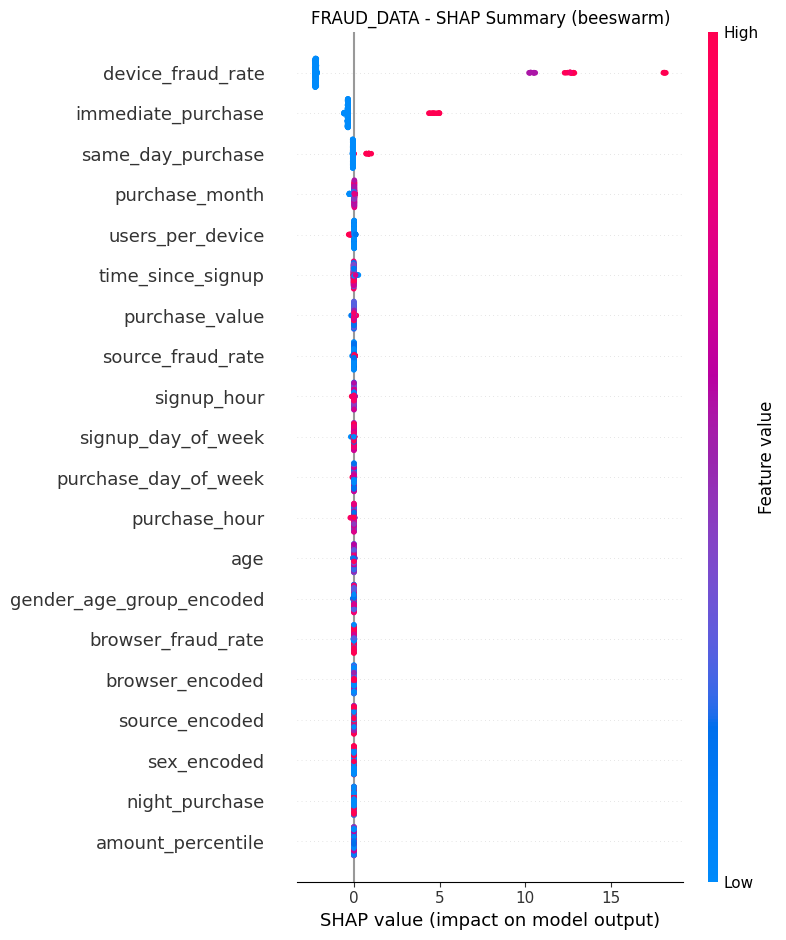

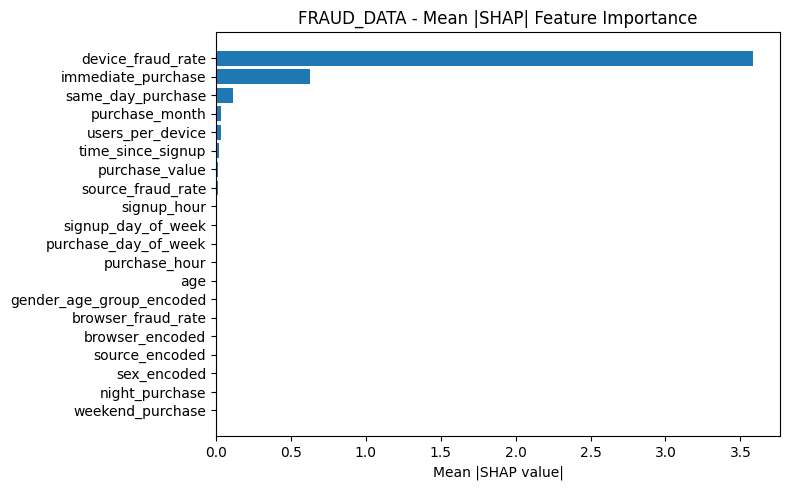

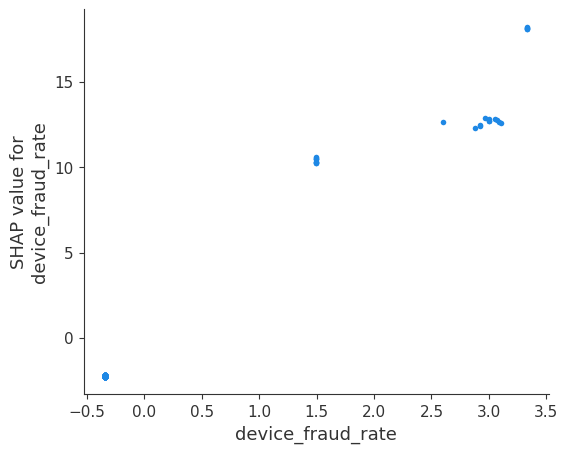

<Figure size 1800x400 with 0 Axes>

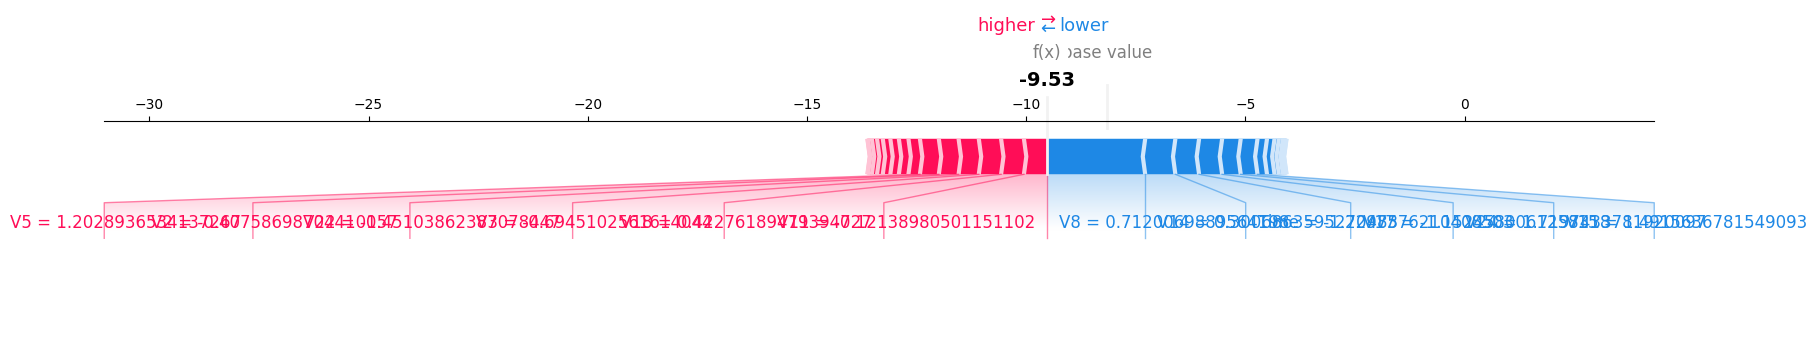

[('device_fraud_rate', -2.2764472484961153, -0.3446744959522699), ('immediate_purchase', -0.33217964408919215, -0.2307772729941308), ('same_day_purchase', -0.06165205760858953, -0.24803766425511983), ('purchase_month', 0.025194760367739946, 1.124310114999982), ('users_per_device', 0.013563160875346512, -0.2615135500539275), ('time_since_signup', -0.012166975348663981, 1.511736283875139), ('signup_hour', 0.004106269337935373, 0.6520313848325152), ('signup_day_of_week', -0.0033725925581529737, -0.5118496049755924), ('gender_age_group_encoded', -0.0020474621723406018, 1.1103999238345805), ('purchase_value', 0.001981282961787656, 0.38556691831065504)]


In [52]:
# after training and selecting best models:
fraud_model = trainer.models["fraud_data"][fraud_best_model]
cc_model = trainer.models["credit_card"][cc_best_model]

explainer = AdvancedSHAPExplainer()
explainer.init_explainer(fraud_model, X_fraud_train, X_fraud_final.columns.tolist(), "fraud_data")
explainer.init_explainer(cc_model, X_cc_train, X_cc_final.columns.tolist(), "credit_card")

# compute shap (cached)
fraud_shap, fraud_X_sample, fraud_expected = explainer.compute_shap("fraud_data", X_fraud_test, max_samples=200)
cc_shap, cc_X_sample, cc_expected = explainer.compute_shap("credit_card", X_cc_test, max_samples=200)

# plots & explanations
explainer.plot_summary("fraud_data", top_n=20)
instance_explanation = explainer.explain_instance("fraud_data", fraud_model, X_fraud_test.iloc[[0]])

# dependency plot for top feature in fraud_data
explainer.plot_dependency("fraud_data", feature="device_fraud_rate")

# force plot for first instance in credit card test set
explainer.plot_force("credit_card", idx=0)

# instance explanation (no waterfall bar, just values)
instance_exp = explainer.explain_instance("fraud_data", fraud_model, X_fraud_test.iloc[[0]])
print(instance_exp["top_features"])